In [1]:
import pandas as pd

import dask
from dask import delayed
import dask.dataframe as dd

import config
import os

import math
import geopandas as gpd
from shapely.geometry import Polygon

folder = config.jiaotongsai_dataset
filepath = [os.path.join(folder, file)
            for file in os.listdir(folder)
            if file.endswith('.txt') and not file.startswith('.')]

In [2]:
# Load data lazily
ddf = dd.read_csv(filepath, header=None,
                  names=['id', 'lat', 'lon', 'st', 'dt'])
# Drop a column
ddf = ddf.drop(columns=['st'])
# Convert from sting to datetime
ddf['dt'] = dd.to_datetime(ddf['dt'])

ddf

,id,lat,lon,dt
npartitions=911,,,,
,int64,float64,float64,datetime64[ns]
,...,...,...,...
...,...,...,...,...
,...,...,...,...
,...,...,...,...


## Func: dealVehicle.py, dealHighFreVehicle.py -> VehicleData_dealed/result.txt

统计每名工人在当月出现天数，统计当月每天有哪些工人。

In [3]:
worker2ndays_path = './output/worker2ndays.csv'
date2workers_path = './output/date2workers.csv'

if not all(os.path.exists(path) for path in filepath):
    ddf['date'] = ddf['dt'].dt.date
    worker2ndays = ddf.drop_duplicates(subset=['id', 'date']).groupby('id')[
        'date'].count().to_frame('n_days')
    date2workers = ddf.drop_duplicates(subset=['id', 'date']).groupby('date')[
        'id'].unique().to_frame('ids')
    worker2ndays, date2workers = dd.compute(worker2ndays, date2workers)

    worker2ndays.to_csv(worker2ndays_path)
    date2workers['ids'] = date2workers['ids'].apply(list)
    date2workers.to_csv(date2workers_path)

worker2ndays = dd.read_csv(worker2ndays_path)
date2workers = dd.read_csv(date2workers_path)

In [6]:
threshold = 25
if not os.path.exists('./output/worker2ndays_25.csv'):
    workers = worker2ndays[worker2ndays['n_days'] >= threshold]
    workers = workers.compute().to_csv('./output/worker2ndays_25.csv')

## Func: getMaxMinLonLat.py

以上述活跃司机为基准，从中选择2000名工人，横跨当月每一天，统计最大最小的经纬度。

In [17]:
workers = pd.read_csv('./output/worker2ndays_25.csv',
                      index_col=0).reset_index(drop=True)
N = 1140
worker_ids = workers['id'].sort_values(ascending=True)[:N]
pd.DataFrame(worker_ids).to_csv('./output/selected_worker.csv')

In [12]:
concern = ddf[ddf['id'].isin(worker_ids)][['lat', 'lon']]
min_lat, max_lat = concern['lat'].min(), concern['lat'].max()
min_lon, max_lon = concern['lon'].min(), concern['lon'].max()
min_lat, max_lat, min_lon, max_lon = dd.compute(
    min_lat, max_lat, min_lon, max_lon)

/Users/durui/miniconda3/lib/python3.11/site-packages/dask/dataframe/core.py:7021: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = func(*args, **kwargs)


In [14]:
geo = pd.DataFrame({'min_lat': [min_lat], 'max_lat': [
                   max_lat], 'min_lon': [min_lon], 'max_lon': [max_lon]})
geo.to_csv('./output/geometry.csv')

## Func: setAllDataGridLabel.py

为上述选择的工人添加一列，标识栅格标签，将离散的数据点聚集至栅格中；按照每一天统计途径该栅格的工人有多少个，有哪些。

### 研究区域栅格生成

In [22]:
_, min_lat, max_lat, min_lon, max_lon = pd.read_csv(
    './output/geometry.csv').iloc[0]

# 定义栅格大小，单位为米
accuracy = 500

# 计算经纬度增量，地球半径取6371004米
R = 6371004
delta_lat = accuracy * 360 / (2 * math.pi * R)
delta_lon = accuracy * 360 / \
    (2 * math.pi * R * math.cos((min_lat + max_lat) * math.pi / 360))

delta_lat, delta_lon

(0.004496605206422906, 0.005227427203548936)

In [23]:
def gps2grid(lat, lon):
    """ 计算该GPS点对应的栅格编号 """
    LON_IDX = divmod(float(lon) - (min_lon - delta_lon / 2), delta_lon)
    LAT_IDX = divmod(float(lat) - (min_lat - delta_lat / 2), delta_lat)
    return LAT_IDX, LON_IDX


def grid2gps(LAT_IDX, LON_IDX):
    """ 计算栅格编号对应的中心点经纬度 """
    return LAT_IDX * delta_lat + min_lat, LON_IDX * delta_lon + min_lon

In [29]:
# 定义空的GeoDataFrame，再往里添加栅格
data = gpd.GeoDataFrame()

# 定义空的list，后面循环一次就往里添加东西
lon_idx, lat_idx = [], []
geometry = []
lon_hb, lat_hb = [], []

# 计算行列要生成的栅格数量
lon_sum = int((max_lon - min_lon) / delta_lon) + 1
lat_sum = int((max_lat - min_lat) / delta_lat) + 1

for i in range(lon_sum):
    for j in range(lat_sum):
        # 第i列，第j行的栅格中心
        HBLON = i * delta_lon + min_lon
        HBLAT = j * delta_lat + min_lat

        # 用周围的栅格推算三个顶点位置
        HBLON_1 = (i+1) * delta_lon + min_lon
        HBLAT_1 = (j+1) * delta_lat + min_lat

        # 生成栅格的 Polygon
        grid_ij = Polygon([
            (HBLON-delta_lon / 2, HBLAT - delta_lat / 2),
            (HBLON_1-delta_lon / 2, HBLAT - delta_lat / 2),
            (HBLON_1-delta_lon / 2, HBLAT_1 - delta_lat / 2),
            (HBLON-delta_lon / 2, HBLAT_1 - delta_lat / 2),
        ])

        # 把生成的数据加入前面定义的list里面
        lon_idx.append(i)
        lat_idx.append(j)
        lon_hb.append(HBLON)
        lat_hb.append(HBLAT)
        geometry.append(grid_ij)

data['lon_idx'] = lon_idx
data['lat_idx'] = lat_idx
data['lon_hb'] = lon_hb
data['lat_hb'] = lat_hb
data['geometry'] = geometry

data

/var/folders/v5/q82y10q11y795vj91pc1thgr0000gn/T/ipykernel_51094/2044679692.py:42: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')` to explicitly set the active geometry column.
  data['geometry'] = geometry


,lon_idx,lat_idx,lon_hb,lat_hb,geometry
0,0,0,103.269824,30.290660,"POLYGON ((103.26721 30.28841, 103.27244 30.288..."
1,0,1,103.269824,30.295157,"POLYGON ((103.26721 30.29291, 103.27244 30.292..."
2,0,2,103.269824,30.299653,"POLYGON ((103.26721 30.29740, 103.27244 30.297..."
3,0,3,103.269824,30.304150,"POLYGON ((103.26721 30.30190, 103.27244 30.301..."
4,0,4,103.269824,30.308646,"POLYGON ((103.26721 30.30640, 103.27244 30.306..."
...,...,...,...,...,...
42400,256,160,104.608045,31.010117,"POLYGON ((104.60543 31.00787, 104.61066 31.007..."
42401,256,161,104.608045,31.014613,"POLYGON ((104.60543 31.01237, 104.61066 31.012..."
42402,256,162,104.608045,31.019110,"POLYGON ((104.60543 31.01686, 104.61066 31.016..."
42403,256,163,104.608045,31.023607,"POLYGON ((104.60543 31.02136, 104.61066 31.021..."


<Axes: >

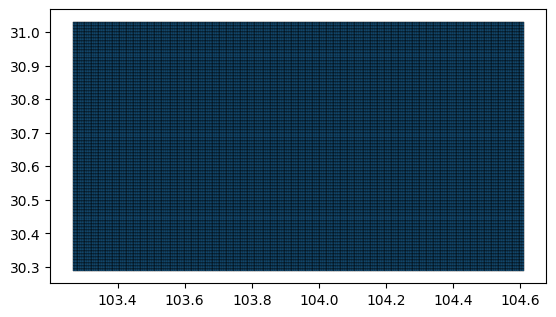

In [31]:
data.plot(edgecolor=(0, 0, 0, 1), linewidth=0.3)

### GPS数据栅格对应与集计

In [32]:
ddf

,id,lat,lon,dt
npartitions=911,,,,
,int64,float64,float64,datetime64[ns]
,...,...,...,...
...,...,...,...,...
,...,...,...,...
,...,...,...,...


In [40]:
# 数据所对应栅格编号

ddf['lon_idx'] = ((ddf['lon'] - (min_lon - delta_lon / 2)) /
                  delta_lon).astype('int')
ddf['lat_idx'] = ((ddf['lat'] - (min_lat - delta_lat / 2)) /
                  delta_lat).astype('int')

ddf.to_parquet('./output/ddf/')

/Users/durui/miniconda3/lib/python3.11/site-packages/dask/dataframe/core.py:7021: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = func(*args, **kwargs)


## getArrivePro.py, getQualific.py

对一个特定的工人、任务：

Arrivepro：有记录天数除以总天数计算，代表到达当前任务的概率；

qPro：质量达标天数除以有记录天数，代表完成该任务的概率。

In [2]:
ddf = dd.read_parquet('./output/ddf/')
ddf['date'] = ddf['dt'].dt.date
ddf['grid'] = ddf['lat_idx'].astype(str) + '-' + ddf['lon_idx'].astype(str)
ddf = ddf[['id', 'dt', 'date', 'grid']]
ddf.head()

,id,dt,date,grid
0,1,2014-08-03 21:18:46,2014-08-03,74-166
1,1,2014-08-03 21:18:15,2014-08-03,74-166
2,1,2014-08-03 21:20:17,2014-08-03,74-166
3,1,2014-08-03 21:19:16,2014-08-03,74-166
4,1,2014-08-03 21:17:44,2014-08-03,74-166


In [4]:
ddf = ddf.sort_values(['id', 'dt', 'grid'])
ddf['time_diff'] = ddf['dt'].diff()

# 将与上一行不同的id和grid的时间差设置为NaT
mask = (ddf['id'] != ddf['id'].shift()) | (ddf['grid'] != ddf['grid'].shift())
ddf['time_diff'] = ddf['time_diff'].mask(mask)

# 累积小于30秒的时间差
ddf['stay_time'] = ddf['time_diff'].apply(
    lambda x: x if x < pd.Timedelta(seconds=30) else pd.Timedelta(seconds=0))

# 按照 id, date, grid 分组并计算停留时间
stay_duration = ddf.groupby(['id', 'date', 'grid'])['stay_time'].sum().reset_index()

# 计算结果
stay_duration.to_parquet('/Volumes/WD_BLACK/dataset/output/car_info/')

: 